In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-04-09 17:00:19.607585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = '../input/cleanDataset/'


In [3]:
# review number of files and directories in the dataset
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)

counting: ../input/cleanDataset/
total files in dir: 0
counting: ../input/cleanDataset/paper
total files in dir: 594
counting: ../input/cleanDataset/metal
total files in dir: 410
counting: ../input/cleanDataset/cardboard
total files in dir: 403
counting: ../input/cleanDataset/trash
total files in dir: 137
counting: ../input/cleanDataset/glass
total files in dir: 501
counting: ../input/cleanDataset/plastic
total files in dir: 482
--------
total number of files 2527
total number of directories 6


In [4]:
# create datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


2024-04-09 17:05:00.412190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


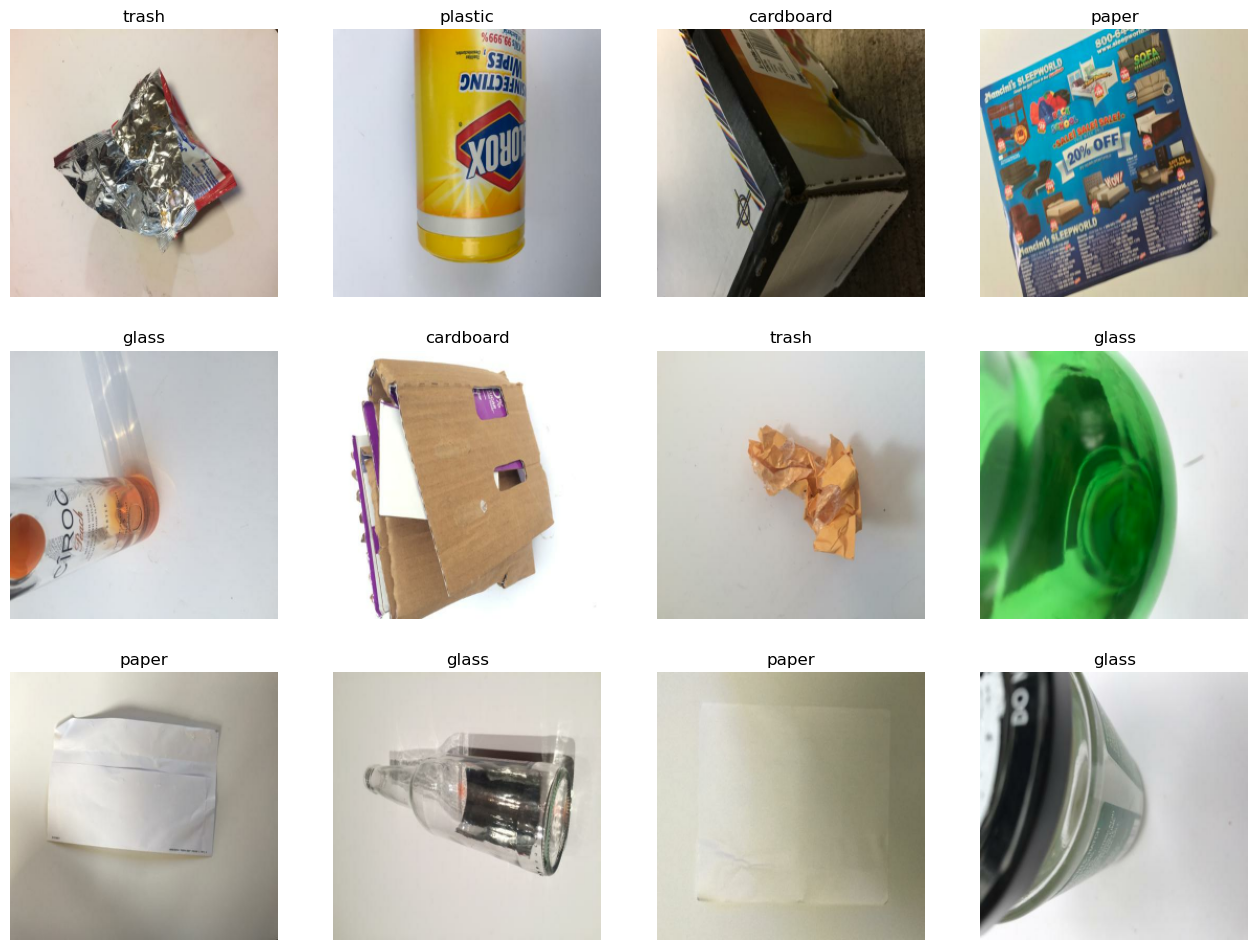

In [6]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

2024-04-09 17:05:23.560634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


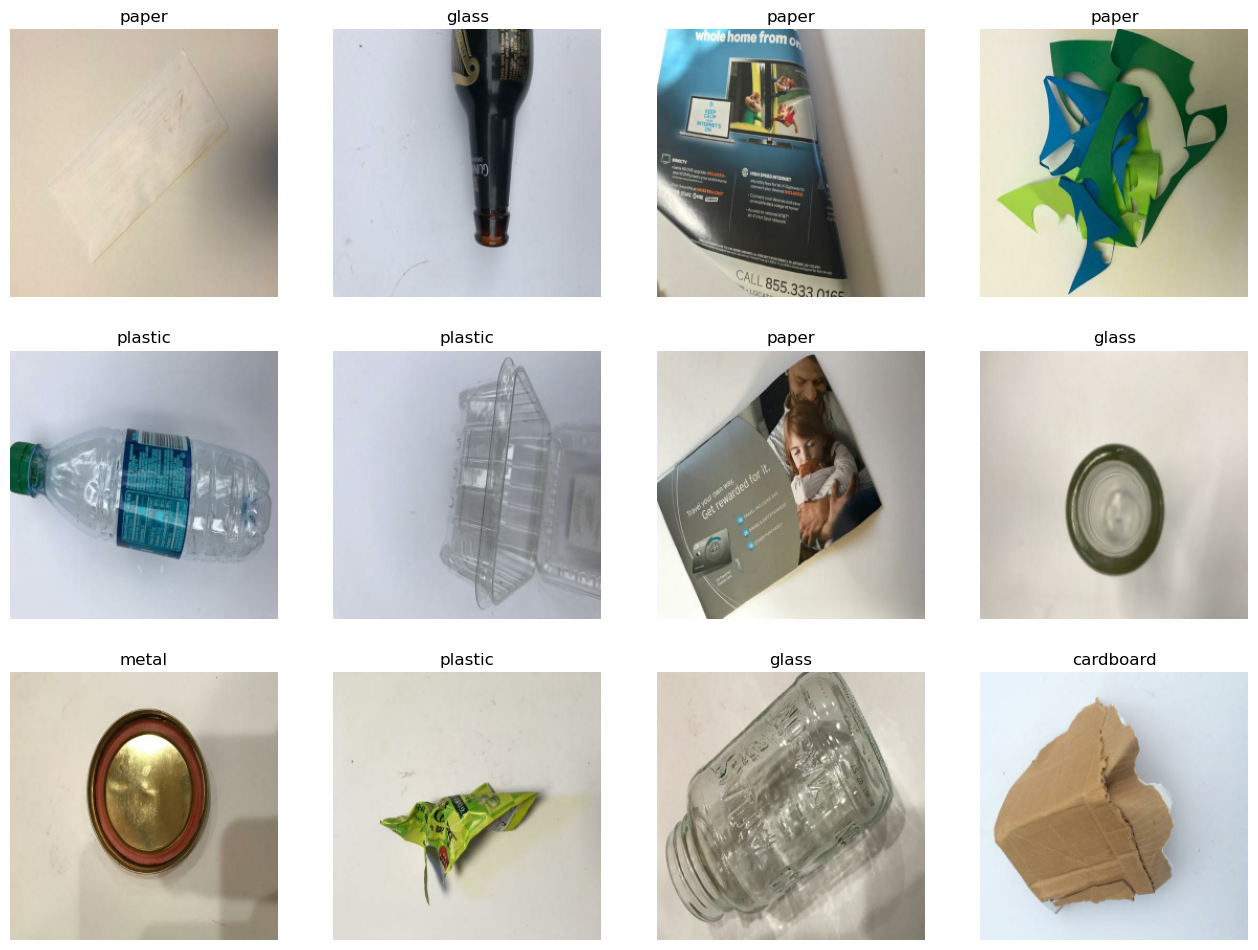

In [7]:
# view some images from the validation_ds
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# inspect the train_ds
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 64
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [9]:
# inspect the validation_ds
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 16
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [10]:
# instantiate the base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

# make the layers of the model trainable to fine-tunning
base_model.trainable = True

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# review the base model architecture
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [12]:
# find the tunning layer and its index
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# freeze all the layers before the tuning layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

In [14]:
# create a data augmentation stage with horizontal and vertical flipping, rotations and zooms
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

In [16]:
# Créer une étape d'augmentation de données avec des retournements horizontaux et verticaux, des rotations et des zooms
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

# Créer le modèle de réseau neuronal
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Définir le taux d'apprentissage
learning_rate = 0.00001

# Compiler le modèle avec l'optimiseur Adam en spécifiant le taux d'apprentissage
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Spécifier learning_rate ici
    metrics=['accuracy']
)

In [17]:
# train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.2558 - loss: 1.8738 - val_accuracy: 0.5426 - val_loss: 1.2389
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.5627 - loss: 1.2286 - val_accuracy: 0.6950 - val_loss: 0.8795
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.7006 - loss: 0.9268 - val_accuracy: 0.7604 - val_loss: 0.7141
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.7477 - loss: 0.7828 - val_accuracy: 0.7881 - val_loss: 0.6162
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.7887 - loss: 0.6690 - val_accuracy: 0.8020 - val_loss: 0.5536
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.8073 - loss: 0.5799 - val_accuracy: 0.8198 - val_loss: 0.5120
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.8252 - loss: 0.5224 - val_accuracy: 0.8317 - val_loss: 0.4782
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.8569 - loss: 0.4747 - val_accuracy: 0.8495 - v

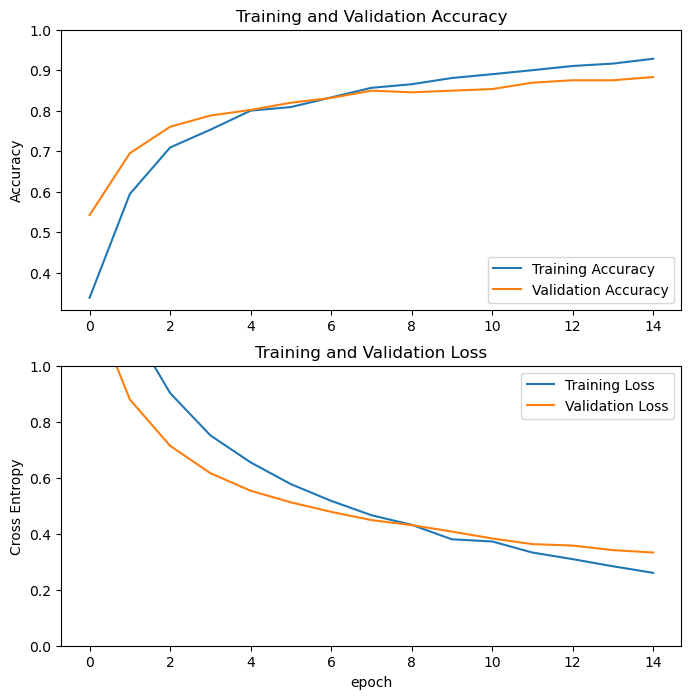

In [18]:
# visualize the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# verify the performance of the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8862 - loss: 0.3257
Test accuracy : 0.8831683397293091
Test loss: 0.33009669184684753


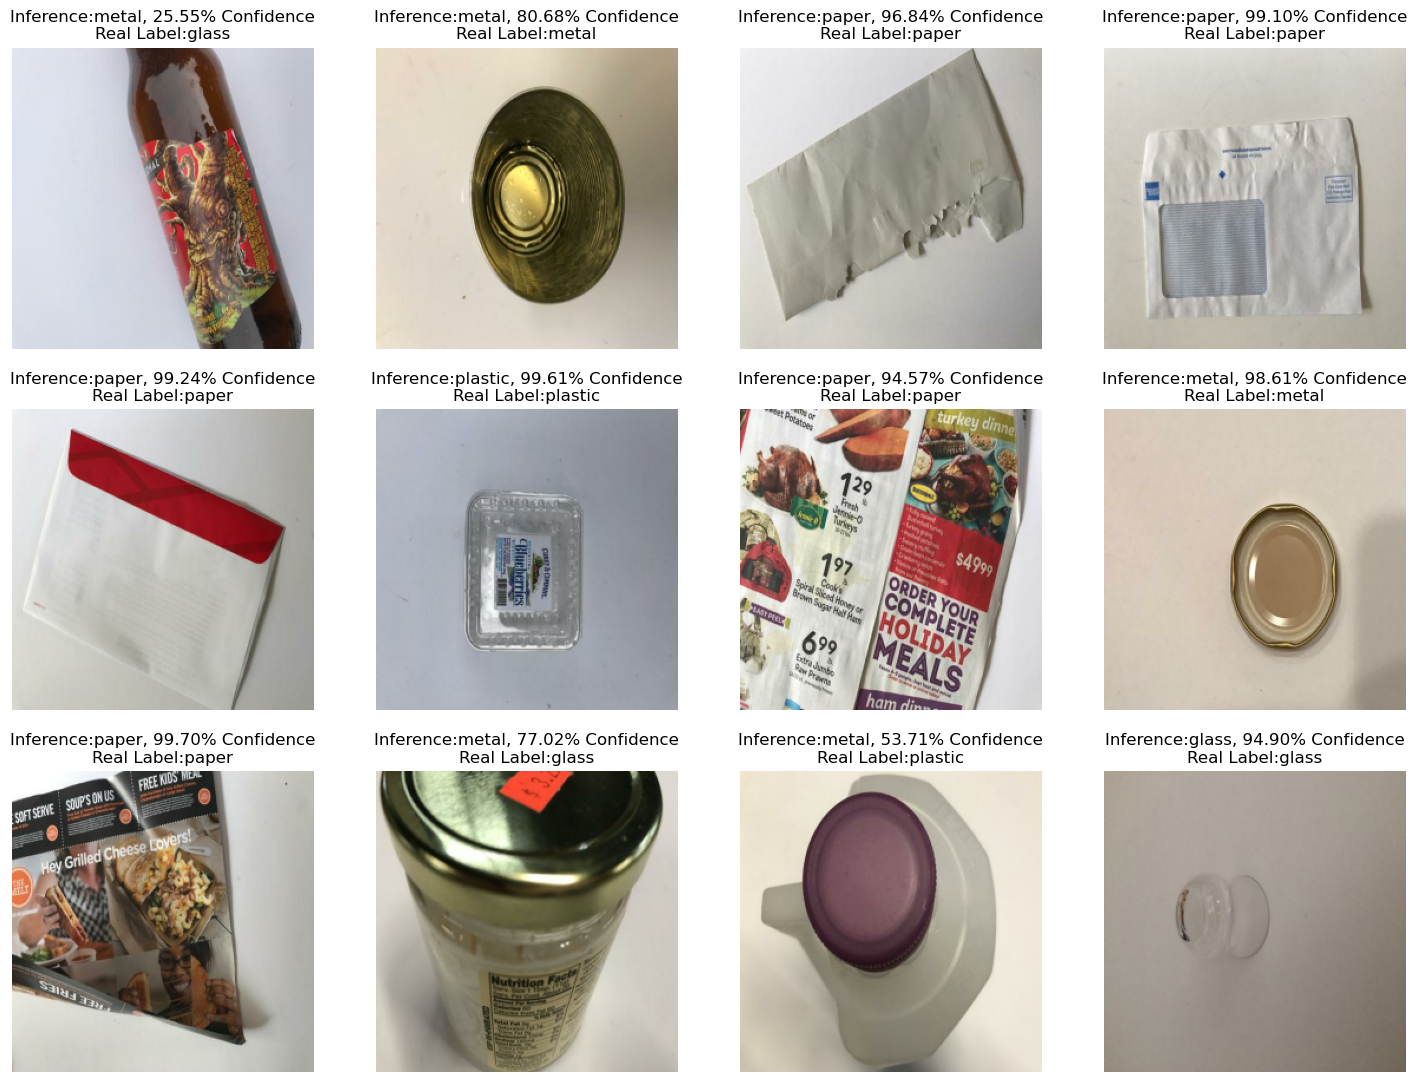

In [20]:
# get a batch from validation_ds to do some inference
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

# inference
inference = model.predict_on_batch(image_batch)

# show imgs and labels
plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% Confidence\nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

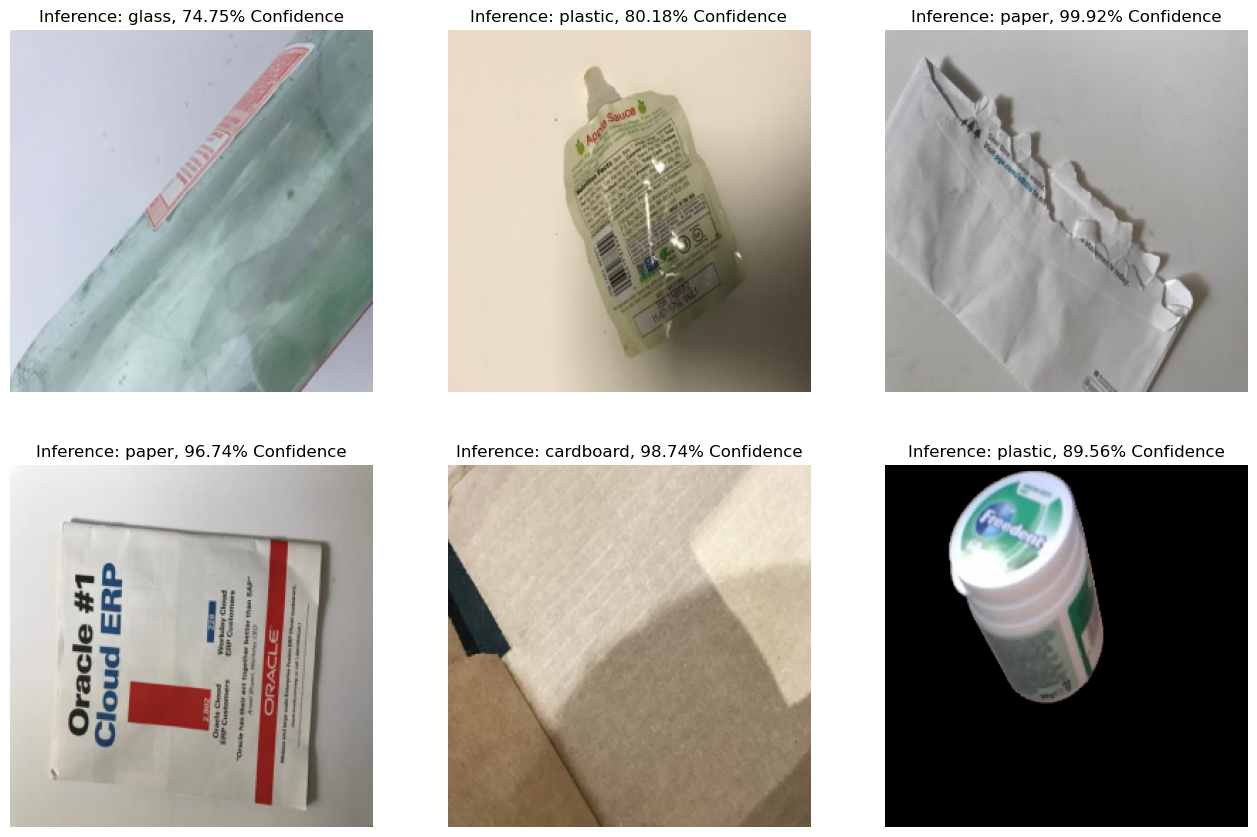

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Chemins des images locales
local_image_paths = [
    'test-images/white-glass1139.jpg',
    'test-images/trash1.jpg',
    'test-images/paper404.jpg',
    'test-images/paper403.jpg',
    'test-images/cardboard47.jpg',
    'test-images/test.png',
    
    
]

# Créer le dataset de test
test_ds = []
image_size = (256, 256)
for path in local_image_paths:
    img = cv2.imread(path)  # Charger l'image à partir du chemin local
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB (Matplotlib utilise RGB)
    img = cv2.resize(img, image_size)  # Redimensionner l'image
    test_ds.append(img)
test_ds = np.array(test_ds)

# Inférence
test_inference = model.predict_on_batch(test_ds)

# Afficher les images avec les prédictions
plt.figure(figsize=(16, 16))
for i in range(len(local_image_paths)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title('Inference: {}, {:.2f}% Confidence'
              .format(class_names[np.argmax(test_inference[i])], 100 * np.max(test_inference[i])))
    plt.axis("off")

plt.show()